# Chronic Disease Disparities & Healthcare Access: A Geospatial Analysis

**Author:** John Apel | M.S. Applied Data Science, Syracuse University

This notebook builds a reproducible ETL pipeline that integrates county-level health data from the **CDC PLACES** program with socioeconomic indicators from the **U.S. Census Bureau** to map the geographic intersection of chronic disease burden, healthcare access, and poverty across nearly 3,000 U.S. counties.

**Research Questions:**
1. Where do chronic disease, lack of healthcare access, and poverty converge geographically?
2. Which health and socioeconomic factors are most strongly correlated at the county level?
3. How do health outcomes in Western North Carolina compare to state and national averages — and how much do they vary within the region?

**Data Sources:**
- CDC PLACES (2024 release) — county-level health estimates from BRFSS
- U.S. Census Bureau American Community Survey (2022, 5-year estimates)
- Census TIGER/Line shapefiles for county boundary geometries


In [67]:
# ============================================================
# Chronic Disease Disparities & Healthcare Access Pipeline
# Step 1: CDC PLACES Data Ingestion (County Level)
# ============================================================


# --- Cell 1: Setup & Imports ---

!pip install geopandas folium mapclassify -q

import pandas as pd
import numpy as np
import requests
import time
import warnings
warnings.filterwarnings('ignore')

print("✅ Packages installed and imported")

✅ Packages installed and imported


---
## Step 1: CDC PLACES Data Ingestion

The CDC's [PLACES](https://www.cdc.gov/places/) program provides model-based estimates for 40 health measures at the county, place, census tract, and ZIP code levels. We'll pull data via the Socrata REST API on `data.cdc.gov`.

We start by fetching three core chronic disease measures: **diabetes prevalence**, **obesity prevalence**, and **coronary heart disease (CHD)** prevalence among adults.


In [68]:

# --- Cell 2: Fetch CDC PLACES County Data via Socrata REST API ---


PLACES_BASE = "https://data.cdc.gov/resource/swc5-untb.json"

def fetch_places_data(measure_id, limit=10000):
    """
    Fetch CDC PLACES county-level data via Socrata REST API.

    Args:
        measure_id: Short measure identifier (e.g., 'DIABETES', 'OBESITY')
        limit: Max records to return

    Returns:
        DataFrame with PLACES indicator data
    """
    params = {
        "$where": f"measureid='{measure_id}'",
        "$limit": limit
    }

    try:
        print(f"⏳ Fetching {measure_id} data from CDC PLACES...")
        resp = requests.get(PLACES_BASE, params=params, timeout=60)
        resp.raise_for_status()
        data = resp.json()
        df = pd.DataFrame(data)
        print(f"✅ Retrieved {len(df)} records for {measure_id}")
        return df
    except requests.exceptions.HTTPError as e:
        print(f"❌ HTTP Error fetching {measure_id}: {e}")
        print(f"   Status code: {resp.status_code}")
        print(f"   Response: {resp.text[:500]}")
        return pd.DataFrame()
    except Exception as e:
        print(f"❌ Error fetching {measure_id}: {e}")
        return pd.DataFrame()

In [69]:
# --- Cell 3: First, let's discover what measures are available ---

# Pull a small sample to see the structure and available measures
print("⏳ Fetching sample to discover available measures...")
resp = requests.get(PLACES_BASE, params={"$limit": 5}, timeout=60)
resp.raise_for_status()
sample = pd.DataFrame(resp.json())

print("\n=== COLUMNS ===")
print(sample.columns.tolist())
print("\n=== SAMPLE ROW ===")
print(sample.iloc[0].to_dict())

⏳ Fetching sample to discover available measures...

=== COLUMNS ===
['year', 'stateabbr', 'statedesc', 'locationname', 'datasource', 'category', 'measure', 'data_value_unit', 'data_value_type', 'data_value', 'low_confidence_limit', 'high_confidence_limit', 'totalpopulation', 'totalpop18plus', 'locationid', 'categoryid', 'measureid', 'datavaluetypeid', 'short_question_text', 'geolocation', ':@computed_region_hjsp_umg2', ':@computed_region_skr5_azej']

=== SAMPLE ROW ===
{'year': '2023', 'stateabbr': 'AR', 'statedesc': 'Arkansas', 'locationname': 'Drew', 'datasource': 'BRFSS', 'category': 'Health Outcomes', 'measure': 'Arthritis among adults', 'data_value_unit': '%', 'data_value_type': 'Crude prevalence', 'data_value': '29.9', 'low_confidence_limit': '26.6', 'high_confidence_limit': '33.3', 'totalpopulation': '16945', 'totalpop18plus': '13230', 'locationid': '05043', 'categoryid': 'HLTHOUT', 'measureid': 'ARTHRITIS', 'datavaluetypeid': 'CrdPrv', 'short_question_text': 'Arthritis', 'geol

### Discovering Available Measures

Before filtering, we need to understand the dataset structure — what columns exist, what measures are available, and how records are organized. This discovery step prevents assumptions about field names that could cause errors downstream.


In [70]:

# --- Cell 4: Get all unique measure IDs ---

# Query distinct measures available in the dataset
resp = requests.get(PLACES_BASE, params={
    "$select": "measureid, measure",
    "$group": "measureid, measure",
    "$limit": 100
}, timeout=60)
resp.raise_for_status()
measures = pd.DataFrame(resp.json())

print("=== ALL AVAILABLE MEASURES ===\n")
for _, row in measures.sort_values('measureid').iterrows():
    print(f"  {row['measureid']:20s} → {row['measure']}")

=== ALL AVAILABLE MEASURES ===

  ACCESS2              → Current lack of health insurance among adults aged 18-64 years
  ARTHRITIS            → Arthritis among adults
  BINGE                → Binge drinking among adults
  BPHIGH               → High blood pressure among adults
  BPMED                → Taking medicine to control high blood pressure among adults with high blood pressure
  CANCER               → Cancer (non-skin) or melanoma among adults
  CASTHMA              → Current asthma among adults
  CHD                  → Coronary heart disease among adults
  CHECKUP              → Visits to doctor for routine checkup within the past year among adults
  CHOLSCREEN           → Cholesterol screening among adults
  COGNITION            → Cognitive disability among adults
  COLON_SCREEN         → Colorectal cancer screening among adults aged 45–75 years
  COPD                 → Chronic obstructive pulmonary disease among adults
  CSMOKING             → Current cigarette smoking amon

In [71]:
# --- Cell 5: Fetch our target disease measures ---

# Common PLACES measure IDs (verify these match Cell 4 output):
#   DIABETES   - Diagnosed diabetes among adults aged >=18 years
#   OBESITY    - Obesity among adults aged >=18 years
#   CHD        - Coronary heart disease among adults aged >=18 years
#   HIGHCHOL   - High cholesterol among adults aged >=18 years
#   BPHIGH     - High blood pressure among adults aged >=18 years
#
# Adjust measure IDs below based on what you see in Cell 4.

TARGET_MEASURES = ['DIABETES', 'OBESITY', 'CHD']

dfs = []
for measure in TARGET_MEASURES:
    df = fetch_places_data(measure)
    dfs.append(df)
    time.sleep(1)  # polite pause

df_places = pd.concat(dfs, ignore_index=True)
print(f"\n📊 Total PLACES records: {len(df_places)}")
print(f"Measures: {df_places['measureid'].unique().tolist()}")

# Check what's creating duplicates
print(f"\nYears: {sorted(df_places['year'].unique())}")
print(f"Data value types: {df_places['data_value_type'].unique().tolist()}")

⏳ Fetching DIABETES data from CDC PLACES...
✅ Retrieved 5916 records for DIABETES
⏳ Fetching OBESITY data from CDC PLACES...
✅ Retrieved 5916 records for OBESITY
⏳ Fetching CHD data from CDC PLACES...
✅ Retrieved 5916 records for CHD

📊 Total PLACES records: 17748
Measures: ['DIABETES', 'OBESITY', 'CHD']

Years: ['2023']
Data value types: ['Crude prevalence', 'Age-adjusted prevalence']


### Fetching Target Disease Measures

We pull three disease indicators and immediately filter to the **latest year** and **age-adjusted prevalence** estimates. Age-adjusted rates are preferred for geographic comparisons because they remove the confounding effect of different age distributions across counties — a county with an older population would otherwise appear to have higher disease rates even if the underlying risk is the same.


In [72]:
# --- Cell 5b: Filter to latest year + age-adjusted estimates ---
# Age-adjusted is better for geographic comparisons (removes age structure bias)
latest_year = df_places['year'].max()
print(f"\nFiltering to year={latest_year}, data_value_type='Age-adjusted prevalence'")

df_places = df_places[
    (df_places['year'] == latest_year) &
    (df_places['data_value_type'] == 'Age-adjusted prevalence')
].copy()

print(f"✅ After filtering: {len(df_places)} records")

# Verify no more duplicates
dupes = df_places.groupby(['locationid', 'measureid']).size()
print(f"Max rows per county/measure: {dupes.max()} (should be 1)")


Filtering to year=2023, data_value_type='Age-adjusted prevalence'
✅ After filtering: 8874 records
Max rows per county/measure: 1 (should be 1)


In [73]:
# --- Cell 6: Explore the raw data ---

print(f"=== SHAPE: {df_places.shape} ===\n")
print("=== DATA TYPES ===")
print(df_places.dtypes)
print(f"\n=== SAMPLE ===")
df_places.head(3)

=== SHAPE: (8874, 22) ===

=== DATA TYPES ===
year                          object
stateabbr                     object
statedesc                     object
locationname                  object
datasource                    object
category                      object
measure                       object
data_value_unit               object
data_value_type               object
data_value                    object
low_confidence_limit          object
high_confidence_limit         object
totalpopulation               object
totalpop18plus                object
locationid                    object
categoryid                    object
measureid                     object
datavaluetypeid               object
short_question_text           object
geolocation                   object
data_value_footnote_symbol    object
data_value_footnote           object
dtype: object

=== SAMPLE ===


year stateabbr statedesc locationname datasource         category  \
9   2023        AL   Alabama     Marshall      BRFSS  Health Outcomes   
12  2023        AL   Alabama    Covington      BRFSS  Health Outcomes   
15  2023        AR  Arkansas    Hempstead      BRFSS  Health Outcomes   

                            measure data_value_unit          data_value_type  \
9   Diagnosed diabetes among adults               %  Age-adjusted prevalence   
12  Diagnosed diabetes among adults               %  Age-adjusted prevalence   
15  Diagnosed diabetes among adults               %  Age-adjusted prevalence   

   data_value  ... totalpopulation totalpop18plus locationid categoryid  \
9        12.4  ...          100756          74538      01095    HLTHOUT   
12       12.8  ...           37952          29514      01039    HLTHOUT   
15       13.6  ...           19343          14429      05057    HLTHOUT   

   measureid datavaluetypeid short_question_text  \
9   DIABETES       AgeAdjPrv            Diabetes   
12  DIABETES       AgeAdjPrv            Diabetes   
15  DIABETES       AgeAdjPrv            Diabetes   

                                          geolocation  \
9   {'type': 'Point', 'coordinates': [-86.30620232...   
12  {'type': 'Point', 'coordinates': [-86.45144490...   
15  {'type': 'Point', 'coordinates': [-93.66821944...   

   data_value_footnote_symbol data_value_footnote  
9                         NaN                 NaN  
12                        NaN                 NaN  
15                        NaN                 NaN  

[3 rows x 22 columns]

### Cleaning and Standardization

This step converts raw API responses into an analysis-ready format: renaming columns for clarity, casting data types, constructing 5-digit FIPS county codes (the standard geographic identifier used across federal datasets), and dropping records with missing values. We also capture confidence intervals for potential use in downstream analysis.


In [74]:
# --- Cell 7: Clean and standardize ---

def clean_places_data(df):
    """
    Clean PLACES county data into analysis-ready format.
    """
    col_map = {
        'stateabbr': 'state_abbr',
        'statedesc': 'state_name',
        'locationname': 'county_name',
        'locationid': 'fips',
        'measureid': 'measure_id',
        'measure': 'measure_name',
        'data_value': 'value',
        'data_value_unit': 'unit',
        'data_value_type': 'value_type',
        'totalpopulation': 'population',
        'low_confidence_limit': 'ci_low',
        'high_confidence_limit': 'ci_high',
        'category': 'category',
        'year': 'year'
    }

    available = {k: v for k, v in col_map.items() if k in df.columns}
    out = df[list(available.keys())].copy()
    out = out.rename(columns=available)

    # Convert types
    out['value'] = pd.to_numeric(out['value'], errors='coerce')
    out['ci_low'] = pd.to_numeric(out['ci_low'], errors='coerce')
    out['ci_high'] = pd.to_numeric(out['ci_high'], errors='coerce')
    if 'population' in out.columns:
        out['population'] = pd.to_numeric(out['population'], errors='coerce')
    out['fips'] = out['fips'].astype(str).str.zfill(5)  # 5-digit county FIPS

    # Drop records with no value
    n_before = len(out)
    out = out.dropna(subset=['value'])
    n_dropped = n_before - len(out)
    if n_dropped > 0:
        print(f"⚠️  Dropped {n_dropped} records with missing values")

    out = out.sort_values(['measure_id', 'state_abbr', 'county_name']).reset_index(drop=True)

    print(f"✅ Cleaned dataset: {out.shape[0]} records")
    print(f"   Counties: {out['fips'].nunique()}")
    print(f"   States: {out['state_abbr'].nunique()}")
    print(f"   Measures: {out['measure_id'].unique().tolist()}")

    return out

df_clean = clean_places_data(df_places)
df_clean.head(10)

⚠️  Dropped 3 records with missing values
✅ Cleaned dataset: 8871 records
   Counties: 2957
   States: 50
   Measures: ['CHD', 'DIABETES', 'OBESITY']


state_abbr state_name           county_name   fips measure_id  \
0         AK     Alaska        Aleutians East  02013        CHD   
1         AK     Alaska        Aleutians West  02016        CHD   
2         AK     Alaska             Anchorage  02020        CHD   
3         AK     Alaska                Bethel  02050        CHD   
4         AK     Alaska           Bristol Bay  02060        CHD   
5         AK     Alaska               Chugach  02063        CHD   
6         AK     Alaska          Copper River  02066        CHD   
7         AK     Alaska                Denali  02068        CHD   
8         AK     Alaska            Dillingham  02070        CHD   
9         AK     Alaska  Fairbanks North Star  02090        CHD   

                          measure_name  value unit               value_type  \
0  Coronary heart disease among adults    6.4    %  Age-adjusted prevalence   
1  Coronary heart disease among adults    5.7    %  Age-adjusted prevalence   
2  Coronary heart disease among adults    5.1    %  Age-adjusted prevalence   
3  Coronary heart disease among adults    8.6    %  Age-adjusted prevalence   
4  Coronary heart disease among adults    5.9    %  Age-adjusted prevalence   
5  Coronary heart disease among adults    5.3    %  Age-adjusted prevalence   
6  Coronary heart disease among adults    6.0    %  Age-adjusted prevalence   
7  Coronary heart disease among adults    5.4    %  Age-adjusted prevalence   
8  Coronary heart disease among adults    7.3    %  Age-adjusted prevalence   
9  Coronary heart disease among adults    5.0    %  Age-adjusted prevalence   

   population  ci_low  ci_high         category  year  
0        3461     5.6      7.3  Health Outcomes  2023  
1        5160     5.0      6.3  Health Outcomes  2023  
2      286075     4.5      5.8  Health Outcomes  2023  
3       18224     7.7      9.7  Health Outcomes  2023  
4         844     5.2      6.6  Health Outcomes  2023  
5        6769     4.6      6.0  Health Outcomes  2023  
6        2674     5.3      6.9  Health Outcomes  2023  
7        1584     4.7      6.0  Health Outcomes  2023  
8        4607     6.4      8.3  Health Outcomes  2023  
9       94840     4.4      5.7  Health Outcomes  2023

### Pivoting to Wide Format

We reshape from long format (one row per county per measure) to wide format (one row per county, one column per measure). This structure is essential for correlation analysis and for merging with other data sources. The pivot also serves as a validation step — if we get roughly 3,000 rows, we know we have one record per county as expected.


In [75]:
# --- Cell 8: Pivot to wide format (one row per county) ---

df_wide = df_clean.pivot_table(
    index=['fips', 'county_name', 'state_abbr', 'state_name'],
    columns='measure_id',
    values='value',
    aggfunc='first'
).reset_index()

df_wide.columns.name = None

# Add population
if 'population' in df_clean.columns:
    pop = df_clean.groupby('fips')['population'].first().reset_index()
    df_wide = df_wide.merge(pop, on='fips', how='left')

print(f"✅ Wide format: {df_wide.shape[0]} counties × {df_wide.shape[1]} columns")
print(f"\n=== COLUMNS ===")
print(df_wide.columns.tolist())
print(f"\n=== SAMPLE ===")
df_wide.head()

✅ Wide format: 2956 counties × 8 columns

=== COLUMNS ===
['fips', 'county_name', 'state_abbr', 'state_name', 'CHD', 'DIABETES', 'OBESITY', 'population']

=== SAMPLE ===


fips county_name state_abbr state_name  CHD  DIABETES  OBESITY  population
0  01001     Autauga         AL    Alabama  5.6      11.4     39.5       60342
1  01003     Baldwin         AL    Alabama  5.5      10.4     35.0      253507
2  01005     Barbour         AL    Alabama  7.4      16.5     47.1       24585
3  01007        Bibb         AL    Alabama  7.0      13.9     43.7       21868
4  01009      Blount         AL    Alabama  6.3      11.3     36.0       59816

### Validation

Before moving on, we verify the data makes sense: checking distributions, confirming value ranges are plausible (diabetes prevalence should be roughly 5-25%, not 50-90%), and looking at which counties rank highest. This quick sanity check catches data quality issues early.


In [76]:
# --- Cell 9: Quick validation & summary stats ---

print("=== SUMMARY STATISTICS (Prevalence %) ===\n")
for measure in TARGET_MEASURES:
    if measure in df_wide.columns:
        stats = df_wide[measure].describe()
        print(f"\n📌 {measure}:")
        print(f"   Mean: {stats['mean']:.1f}%  |  Median: {stats['50%']:.1f}%")
        print(f"   Min:  {stats['min']:.1f}%   |  Max:    {stats['max']:.1f}%")
        print(f"   Std:  {stats['std']:.1f}%")

print(f"\n=== TOP 10 COUNTIES: DIABETES PREVALENCE ===\n")
if 'DIABETES' in df_wide.columns:
    top = df_wide.nlargest(10, 'DIABETES')[['county_name', 'state_abbr', 'DIABETES', 'OBESITY', 'CHD']]
    print(top.to_string(index=False))

=== SUMMARY STATISTICS (Prevalence %) ===


📌 DIABETES:
   Mean: 11.2%  |  Median: 10.7%
   Min:  6.0%   |  Max:    23.8%
   Std:  2.3%

📌 OBESITY:
   Mean: 37.6%  |  Median: 38.2%
   Min:  17.1%   |  Max:    54.0%
   Std:  4.7%

📌 CHD:
   Mean: 6.0%  |  Median: 5.9%
   Min:  3.8%   |  Max:    11.4%
   Std:  0.8%

=== TOP 10 COUNTIES: DIABETES PREVALENCE ===

  county_name state_abbr  DIABETES  OBESITY  CHD
Oglala Lakota         SD      23.8     47.7 11.4
         Todd         SD      22.9     50.2 10.9
       Dimmit         TX      21.5     47.7  8.5
       Zavala         TX      21.4     48.2  8.3
      Bullock         AL      21.3     51.0  8.8
 East Carroll         LA      21.3     51.7  9.5
       Greene         AL      21.1     53.4  8.2
       Holmes         MS      21.0     51.5  8.0
    Humphreys         MS      20.6     53.0  8.3
        Perry         AL      20.5     54.0  8.2


In [77]:
# --- Cell 10: Save checkpoint ---

df_clean.to_csv('places_county_long.csv', index=False)
df_wide.to_csv('places_county_wide.csv', index=False)
print("💾 Saved: places_county_long.csv & places_county_wide.csv")



💾 Saved: places_county_long.csv & places_county_wide.csv


### Scatter Plot: Obesity vs. Diabetes

This initial visualization serves two purposes: it validates that the data shows expected epidemiological relationships (obesity and diabetes should be positively correlated), and it provides a baseline understanding of the strength of that relationship before we introduce additional variables.


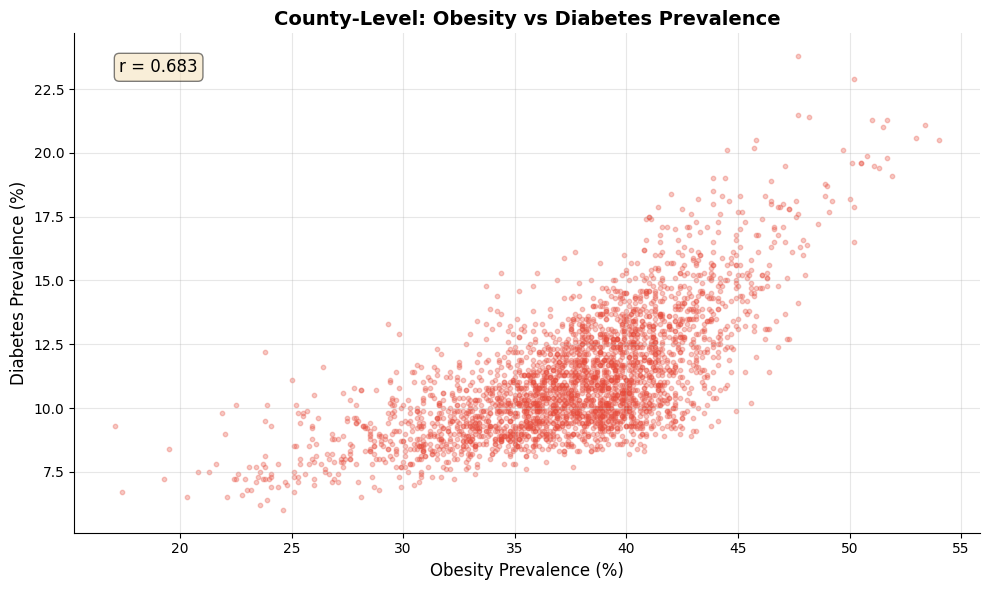

✅ Correlation between obesity and diabetes: 0.683
   If you see a strong positive correlation, your data is solid.


In [78]:

# --- Cell 11: Quick sanity plot ---

import matplotlib.pyplot as plt

if 'DIABETES' in df_wide.columns and 'OBESITY' in df_wide.columns:
    fig, ax = plt.subplots(figsize=(10, 6))

    ax.scatter(
        df_wide['OBESITY'], df_wide['DIABETES'],
        alpha=0.3, s=10, color='#e74c3c'
    )

    ax.set_xlabel('Obesity Prevalence (%)', fontsize=12)
    ax.set_ylabel('Diabetes Prevalence (%)', fontsize=12)
    ax.set_title('County-Level: Obesity vs Diabetes Prevalence', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.spines[['top', 'right']].set_visible(False)

    # Add correlation
    corr = df_wide[['OBESITY', 'DIABETES']].corr().iloc[0, 1]
    ax.text(0.05, 0.95, f'r = {corr:.3f}', transform=ax.transAxes,
            fontsize=12, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    plt.tight_layout()
    plt.savefig('diabetes_obesity_scatter.png', dpi=150, bbox_inches='tight')
    plt.show()
    print(f"✅ Correlation between obesity and diabetes: {corr:.3f}")
    print("   If you see a strong positive correlation, your data is solid.")

---
## Step 2: Healthcare Access & Socioeconomic Data

Disease prevalence alone doesn't tell the full story. To understand *why* some counties have higher chronic disease rates, we need to layer in data on healthcare access and economic conditions.

### Part A: Additional PLACES Health Measures

We return to the same CDC PLACES API to pull four additional measures that capture healthcare access and health behaviors:
- **ACCESS2** — % adults 18-64 without health insurance
- **LPA** — % adults with no leisure-time physical activity
- **CHECKUP** — % adults with a routine checkup in the past year
- **MHLTH** — % adults reporting poor mental health ≥14 days


In [79]:
# ============================================================
# Step 2: Healthcare Access & Socioeconomic Data
# ============================================================


# ============================================================
# PART A: Pull additional PLACES measures (same API, easy win)
# ============================================================

# --- Cell 12: Fetch healthcare access + behavior measures from PLACES ---

# We already know the PLACES API works. Let's grab:
#   ACCESS2 = No health insurance among adults 18-64
#   LPA     = No leisure-time physical activity
#   CHECKUP = Routine checkup within past year
#   MHLTH   = Poor mental health (14+ days)

ACCESS_MEASURES = ['ACCESS2', 'LPA', 'CHECKUP', 'MHLTH']

dfs_access = []
for measure in ACCESS_MEASURES:
    df = fetch_places_data(measure)
    dfs_access.append(df)
    time.sleep(1)

df_access_raw = pd.concat(dfs_access, ignore_index=True)
print(f"\n📊 Total access/behavior records: {len(df_access_raw)}")

# Filter same as before: latest year, age-adjusted
latest_year = df_access_raw['year'].max()
df_access_raw = df_access_raw[
    (df_access_raw['year'] == latest_year) &
    (df_access_raw['data_value_type'] == 'Age-adjusted prevalence')
].copy()

print(f"✅ After filtering: {len(df_access_raw)} records")

⏳ Fetching ACCESS2 data from CDC PLACES...
✅ Retrieved 5916 records for ACCESS2
⏳ Fetching LPA data from CDC PLACES...
✅ Retrieved 5916 records for LPA
⏳ Fetching CHECKUP data from CDC PLACES...
✅ Retrieved 5916 records for CHECKUP
⏳ Fetching MHLTH data from CDC PLACES...
✅ Retrieved 5916 records for MHLTH

📊 Total access/behavior records: 23664
✅ After filtering: 11832 records


In [80]:
# --- Cell 13: Clean and pivot access measures ---

df_access_clean = clean_places_data(df_access_raw)

df_access_wide = df_access_clean.pivot_table(
    index='fips',
    columns='measure_id',
    values='value',
    aggfunc='first'
).reset_index()

df_access_wide.columns.name = None
print(f"✅ Access measures wide: {df_access_wide.shape[0]} counties × {df_access_wide.shape[1]} columns")
print(df_access_wide.head())

⚠️  Dropped 4 records with missing values
✅ Cleaned dataset: 11828 records
   Counties: 2957
   States: 50
   Measures: ['ACCESS2', 'CHECKUP', 'LPA', 'MHLTH']
✅ Access measures wide: 2957 counties × 5 columns
    fips  ACCESS2  CHECKUP   LPA  MHLTH
0  00059     11.5     75.7  23.7   16.3
1  01001      9.1     79.4  26.0   18.0
2  01003      8.8     77.5  23.7   16.8
3  01005     14.8     79.3  34.5   19.9
4  01007     13.0     77.3  31.9   19.9


In [81]:
# --- Cell 14: Merge access measures into main dataset ---

df_merged = df_wide.merge(df_access_wide, on='fips', how='left')
print(f"✅ Merged dataset: {df_merged.shape[0]} counties × {df_merged.shape[1]} columns")
print(f"Columns: {df_merged.columns.tolist()}")

✅ Merged dataset: 2956 counties × 12 columns
Columns: ['fips', 'county_name', 'state_abbr', 'state_name', 'CHD', 'DIABETES', 'OBESITY', 'population', 'ACCESS2', 'CHECKUP', 'LPA', 'MHLTH']


### Part B: Census Bureau Socioeconomic Data

The U.S. Census Bureau's American Community Survey (ACS) provides socioeconomic indicators at the county level. We query the Census REST API for **median household income** and **poverty rate** — two measures widely used in health equity research as proxies for economic well-being.

The Census API is publicly accessible without authentication for basic queries, and returns data keyed by state + county FIPS codes, which we'll combine into 5-digit FIPS codes to match our CDC data.


In [82]:



# ============================================================
# PART B: Census ACS Socioeconomic Data
# ============================================================

# --- Cell 15: Fetch Census ACS data (no API key needed for small queries) ---

# Census ACS 5-Year Estimates — key socioeconomic variables
# We'll use the Census API. A key is recommended but small queries work without one.
# Get a free key instantly at: https://api.census.gov/data/key_signup.html

CENSUS_BASE = "https://api.census.gov/data/2022/acs/acs5"

# Variables we want:
# B19013_001E = Median household income
# S1701_C03_001E = Percent below poverty (from subject tables)
# Note: Subject tables use a different endpoint, so we'll use these:
# B17001_001E = Total population for poverty status
# B17001_002E = Population below poverty level
# B01003_001E = Total population

CENSUS_VARS = {
    'B19013_001E': 'median_household_income',
    'B17001_002E': 'pop_below_poverty',
    'B17001_001E': 'pop_poverty_universe',
    'B01003_001E': 'total_population'
}

def fetch_census_acs(variables, year=2022):
    """
    Fetch county-level ACS 5-year estimates from Census API.
    No API key required for basic queries (but rate-limited).
    """
    var_string = ','.join(variables.keys())
    url = f"https://api.census.gov/data/{year}/acs/acs5"
    params = {
        'get': f'NAME,{var_string}',
        'for': 'county:*'
    }

    try:
        print(f"⏳ Fetching Census ACS {year} data...")
        resp = requests.get(url, params=params, timeout=120)
        resp.raise_for_status()
        data = resp.json()

        # First row is headers, rest is data
        headers = data[0]
        rows = data[1:]
        df = pd.DataFrame(rows, columns=headers)
        print(f"✅ Retrieved {len(df)} county records from Census ACS")
        return df
    except Exception as e:
        print(f"❌ Error: {e}")
        if hasattr(resp, 'text'):
            print(f"   Response preview: {resp.text[:300]}")
        return pd.DataFrame()

df_census_raw = fetch_census_acs(CENSUS_VARS)

⏳ Fetching Census ACS 2022 data...
✅ Retrieved 3222 county records from Census ACS


In [83]:


# --- Cell 16: Clean Census data ---

def clean_census_data(df, var_map):
    """Clean Census ACS data and create derived measures."""
    out = df.copy()

    # Create 5-digit FIPS from state + county codes
    out['fips'] = out['state'].str.zfill(2) + out['county'].str.zfill(3)

    # Rename variables
    out = out.rename(columns=var_map)

    # Convert to numeric
    for col in var_map.values():
        out[col] = pd.to_numeric(out[col], errors='coerce')

    # Calculate poverty rate
    out['poverty_rate'] = (
        out['pop_below_poverty'] / out['pop_poverty_universe'] * 100
    ).round(1)

    # Keep only what we need
    out = out[['fips', 'NAME', 'median_household_income', 'poverty_rate', 'total_population']].copy()
    out = out.rename(columns={'NAME': 'county_full_name'})

    # Drop rows with missing data
    n_before = len(out)
    out = out.dropna(subset=['median_household_income', 'poverty_rate'])
    print(f"⚠️  Dropped {n_before - len(out)} counties with missing Census data")

    print(f"✅ Census data: {len(out)} counties")
    print(f"   Median income range: ${out['median_household_income'].min():,.0f} - ${out['median_household_income'].max():,.0f}")
    print(f"   Poverty rate range: {out['poverty_rate'].min():.1f}% - {out['poverty_rate'].max():.1f}%")

    return out

df_census = clean_census_data(df_census_raw, CENSUS_VARS)
df_census.head()

⚠️  Dropped 0 counties with missing Census data
✅ Census data: 3222 counties
   Median income range: $-666,666,666 - $170,463
   Poverty rate range: 1.6% - 66.3%


fips         county_full_name  median_household_income  poverty_rate  \
0  01001  Autauga County, Alabama                    68315          11.4   
1  01003  Baldwin County, Alabama                    71039          10.2   
2  01005  Barbour County, Alabama                    39712          24.2   
3  01007     Bibb County, Alabama                    50669          20.6   
4  01009   Blount County, Alabama                    57440          14.2   

   total_population  
0             58761  
1            233420  
2             24877  
3             22251  
4             59077

### Merging All Data Sources

This is the core integration step. We join CDC health data with Census socioeconomic data on 5-digit FIPS county codes using a left join — keeping all counties from our health dataset and attaching economic indicators where available. After this merge, each row represents one county with up to 9 measures spanning health outcomes, healthcare access, and economic status.


In [84]:


# --- Cell 17: Merge Census into main dataset ---

df_merged = df_merged.merge(df_census[['fips', 'median_household_income', 'poverty_rate']],
                             on='fips', how='left')

print(f"✅ Full merged dataset: {df_merged.shape[0]} counties × {df_merged.shape[1]} columns")
print(f"\n=== COLUMNS ===")
print(df_merged.columns.tolist())

# Check completeness
print(f"\n=== MISSING VALUES ===")
for col in df_merged.columns:
    missing = df_merged[col].isna().sum()
    if missing > 0:
        print(f"  {col}: {missing} missing ({missing/len(df_merged)*100:.1f}%)")

✅ Full merged dataset: 2956 counties × 14 columns

=== COLUMNS ===
['fips', 'county_name', 'state_abbr', 'state_name', 'CHD', 'DIABETES', 'OBESITY', 'population', 'ACCESS2', 'CHECKUP', 'LPA', 'MHLTH', 'median_household_income', 'poverty_rate']

=== MISSING VALUES ===


In [85]:


# --- Cell 18: Quick validation ---

print("=== SUMMARY: ALL MEASURES ===\n")
numeric_cols = ['DIABETES', 'OBESITY', 'CHD', 'ACCESS2', 'LPA', 'CHECKUP',
                'MHLTH', 'poverty_rate', 'median_household_income']
for col in numeric_cols:
    if col in df_merged.columns:
        stats = df_merged[col].describe()
        print(f"  {col:25s}  mean={stats['mean']:>8.1f}  min={stats['min']:>8.1f}  max={stats['max']:>8.1f}")

=== SUMMARY: ALL MEASURES ===

  DIABETES                   mean=    11.2  min=     6.0  max=    23.8
  OBESITY                    mean=    37.6  min=    17.1  max=    54.0
  CHD                        mean=     6.0  min=     3.8  max=    11.4
  ACCESS2                    mean=    11.7  min=     4.0  max=    43.7
  LPA                        mean=    27.0  min=    12.2  max=    48.9
  CHECKUP                    mean=    74.9  min=    60.2  max=    84.0
  MHLTH                      mean=    18.6  min=    12.7  max=    26.6
  poverty_rate               mean=    14.2  min=     1.6  max=    55.8
  median_household_income    mean= 63613.9  min= 17900.0  max=170463.0


### Correlation Analysis

With all variables in one dataset, we can now examine how health outcomes, healthcare access, and socioeconomic status relate to each other at the county level. The correlation matrix reveals which factors move together — and which relationships are strongest.

Key things to look for:
- Which health measure correlates most strongly with diabetes?
- Does poverty correlate more strongly with disease than lack of insurance?
- Are there any surprising weak correlations?


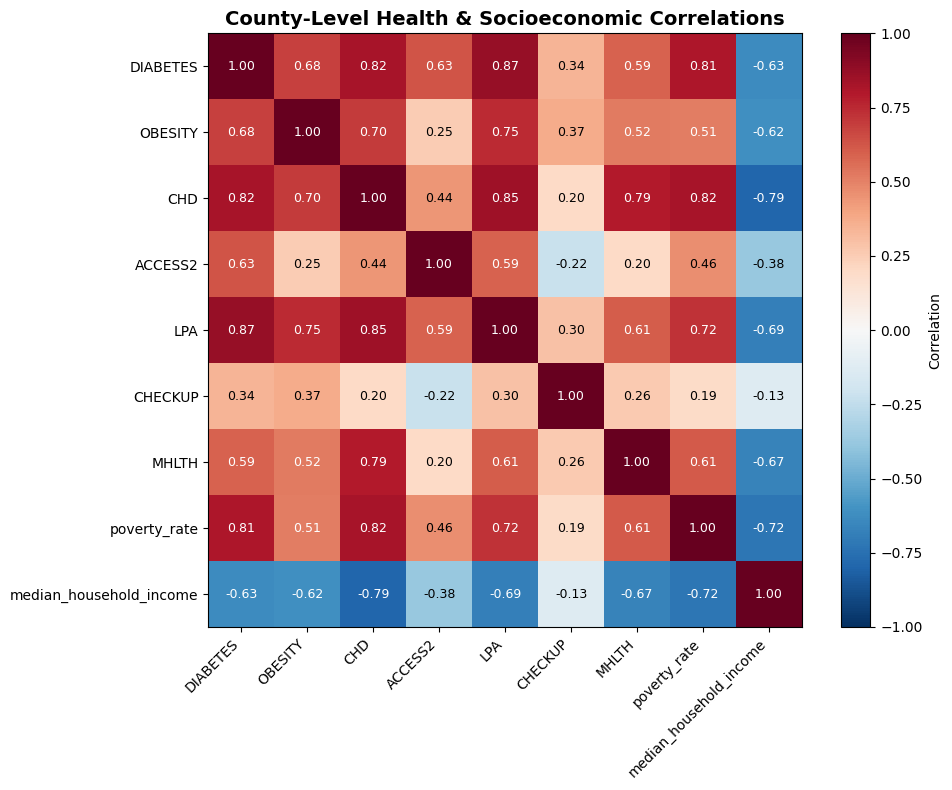

In [86]:

# --- Cell 19: Correlation matrix ---

import matplotlib.pyplot as plt
import matplotlib

corr_cols = [c for c in numeric_cols if c in df_merged.columns]
corr_matrix = df_merged[corr_cols].corr()

fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(corr_matrix, cmap='RdBu_r', vmin=-1, vmax=1)

ax.set_xticks(range(len(corr_cols)))
ax.set_yticks(range(len(corr_cols)))
ax.set_xticklabels(corr_cols, rotation=45, ha='right', fontsize=10)
ax.set_yticklabels(corr_cols, fontsize=10)

# Add correlation values
for i in range(len(corr_cols)):
    for j in range(len(corr_cols)):
        ax.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}',
                ha='center', va='center', fontsize=9,
                color='white' if abs(corr_matrix.iloc[i, j]) > 0.5 else 'black')

plt.colorbar(im, ax=ax, label='Correlation')
ax.set_title('County-Level Health & Socioeconomic Correlations', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

In [87]:


# --- Cell 20: Save full merged dataset ---

df_merged.to_csv('full_merged_dataset.csv', index=False)
print(f"💾 Saved: full_merged_dataset.csv")
print(f"   {df_merged.shape[0]} counties × {df_merged.shape[1]} columns")
print(f"\n🎉 Data integration complete! Ready for geospatial analysis.")
df_merged.head()

💾 Saved: full_merged_dataset.csv
   2956 counties × 14 columns

🎉 Data integration complete! Ready for geospatial analysis.


fips county_name state_abbr state_name  CHD  DIABETES  OBESITY  \
0  01001     Autauga         AL    Alabama  5.6      11.4     39.5   
1  01003     Baldwin         AL    Alabama  5.5      10.4     35.0   
2  01005     Barbour         AL    Alabama  7.4      16.5     47.1   
3  01007        Bibb         AL    Alabama  7.0      13.9     43.7   
4  01009      Blount         AL    Alabama  6.3      11.3     36.0   

   population  ACCESS2  CHECKUP   LPA  MHLTH  median_household_income  \
0       60342      9.1     79.4  26.0   18.0                    68315   
1      253507      8.8     77.5  23.7   16.8                    71039   
2       24585     14.8     79.3  34.5   19.9                    39712   
3       21868     13.0     77.3  31.9   19.9                    50669   
4       59816     12.0     77.0  27.7   18.9                    57440   

   poverty_rate  
0          11.4  
1          10.2  
2          24.2  
3          20.6  
4          14.2

---
## Step 3: Geospatial Analysis & Mapping

Numbers in a table tell part of the story. Maps tell the rest — they reveal geographic clustering, regional patterns, and spatial relationships that aren't visible in summary statistics. 

We load county boundary shapefiles from the Census Bureau's TIGER/Line program and merge our health + socioeconomic data to create map-ready GeoDataFrames.


In [88]:
# ============================================================
# Step 3: Geospatial Analysis & Interactive Maps
# ============================================================


# --- Cell 21: Load county shapefiles ---

import geopandas as gpd
import folium
from folium.features import GeoJsonTooltip
import json

# Census TIGER/Line county boundaries — geopandas can read directly from URL
COUNTIES_URL = "https://www2.census.gov/geo/tiger/GENZ2022/shp/cb_2022_us_county_20m.zip"

print("⏳ Downloading county shapefiles (may take a minute)...")
gdf_counties = gpd.read_file(COUNTIES_URL)
print(f"✅ Loaded {len(gdf_counties)} county geometries")
print(f"   CRS: {gdf_counties.crs}")
print(f"   Columns: {gdf_counties.columns.tolist()}")

# Create 5-digit FIPS
gdf_counties['fips'] = gdf_counties['STATEFP'] + gdf_counties['COUNTYFP']
print(f"   Sample FIPS: {gdf_counties['fips'].head(3).tolist()}")

⏳ Downloading county shapefiles (may take a minute)...
✅ Loaded 3222 county geometries
   CRS: EPSG:4269
   Columns: ['STATEFP', 'COUNTYFP', 'COUNTYNS', 'AFFGEOID', 'GEOID', 'NAME', 'NAMELSAD', 'STUSPS', 'STATE_NAME', 'LSAD', 'ALAND', 'AWATER', 'geometry']
   Sample FIPS: ['17127', '27017', '37181']


In [89]:

# --- Cell 22: Merge data with geometries ---

# Left join: keep all geometries, attach our data
gdf = gdf_counties.merge(df_merged, on='fips', how='left')

# Filter to continental US for cleaner maps (drop AK, HI, territories)
# Keep them in data but exclude from main map
EXCLUDE_STATES = ['02', '15', '60', '66', '69', '72', '78']
gdf_conus = gdf[~gdf['STATEFP'].isin(EXCLUDE_STATES)].copy()

matched = gdf_conus['DIABETES'].notna().sum()
total = len(gdf_conus)
print(f"✅ Merged: {matched}/{total} continental US counties have data ({matched/total*100:.1f}%)")

✅ Merged: 2921/3109 continental US counties have data (94.0%)


### Choropleth Maps: Disease Prevalence

These maps visualize county-level prevalence using quantile classification (6 classes), which ensures each color bin contains roughly the same number of counties. This approach highlights relative differences across the full distribution rather than being skewed by outliers.


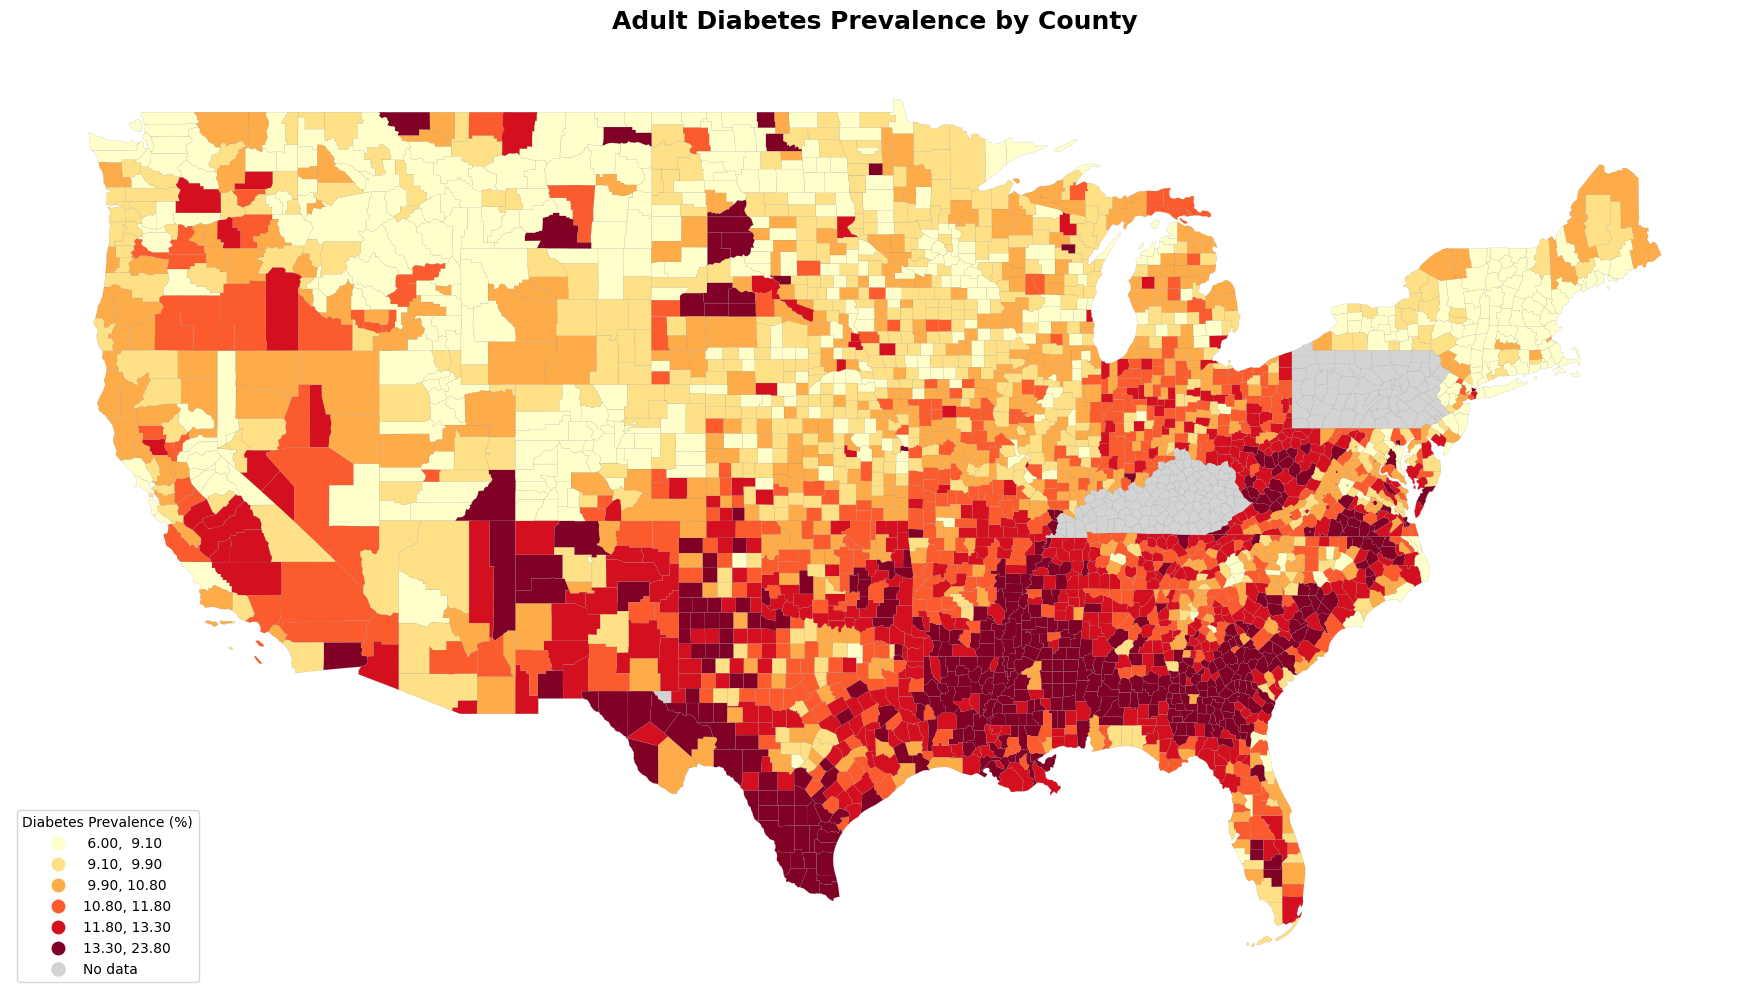

💾 Saved: map_diabetes_prevalence.png


In [90]:


# --- Cell 23: Static choropleth — Diabetes prevalence ---

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

fig, ax = plt.subplots(1, 1, figsize=(18, 10))

gdf_conus.plot(
    column='DIABETES',
    cmap='YlOrRd',
    scheme='quantiles',
    k=6,
    legend=True,
    legend_kwds={'title': 'Diabetes Prevalence (%)', 'loc': 'lower left'},
    ax=ax,
    edgecolor='gray',
    linewidth=0.1,
    missing_kwds={'color': 'lightgray', 'label': 'No data'}
)

ax.set_title('Adult Diabetes Prevalence by County', fontsize=18, fontweight='bold', pad=20)
ax.set_axis_off()
plt.tight_layout()
plt.savefig('map_diabetes_prevalence.png', dpi=200, bbox_inches='tight')
plt.show()
print("💾 Saved: map_diabetes_prevalence.png")

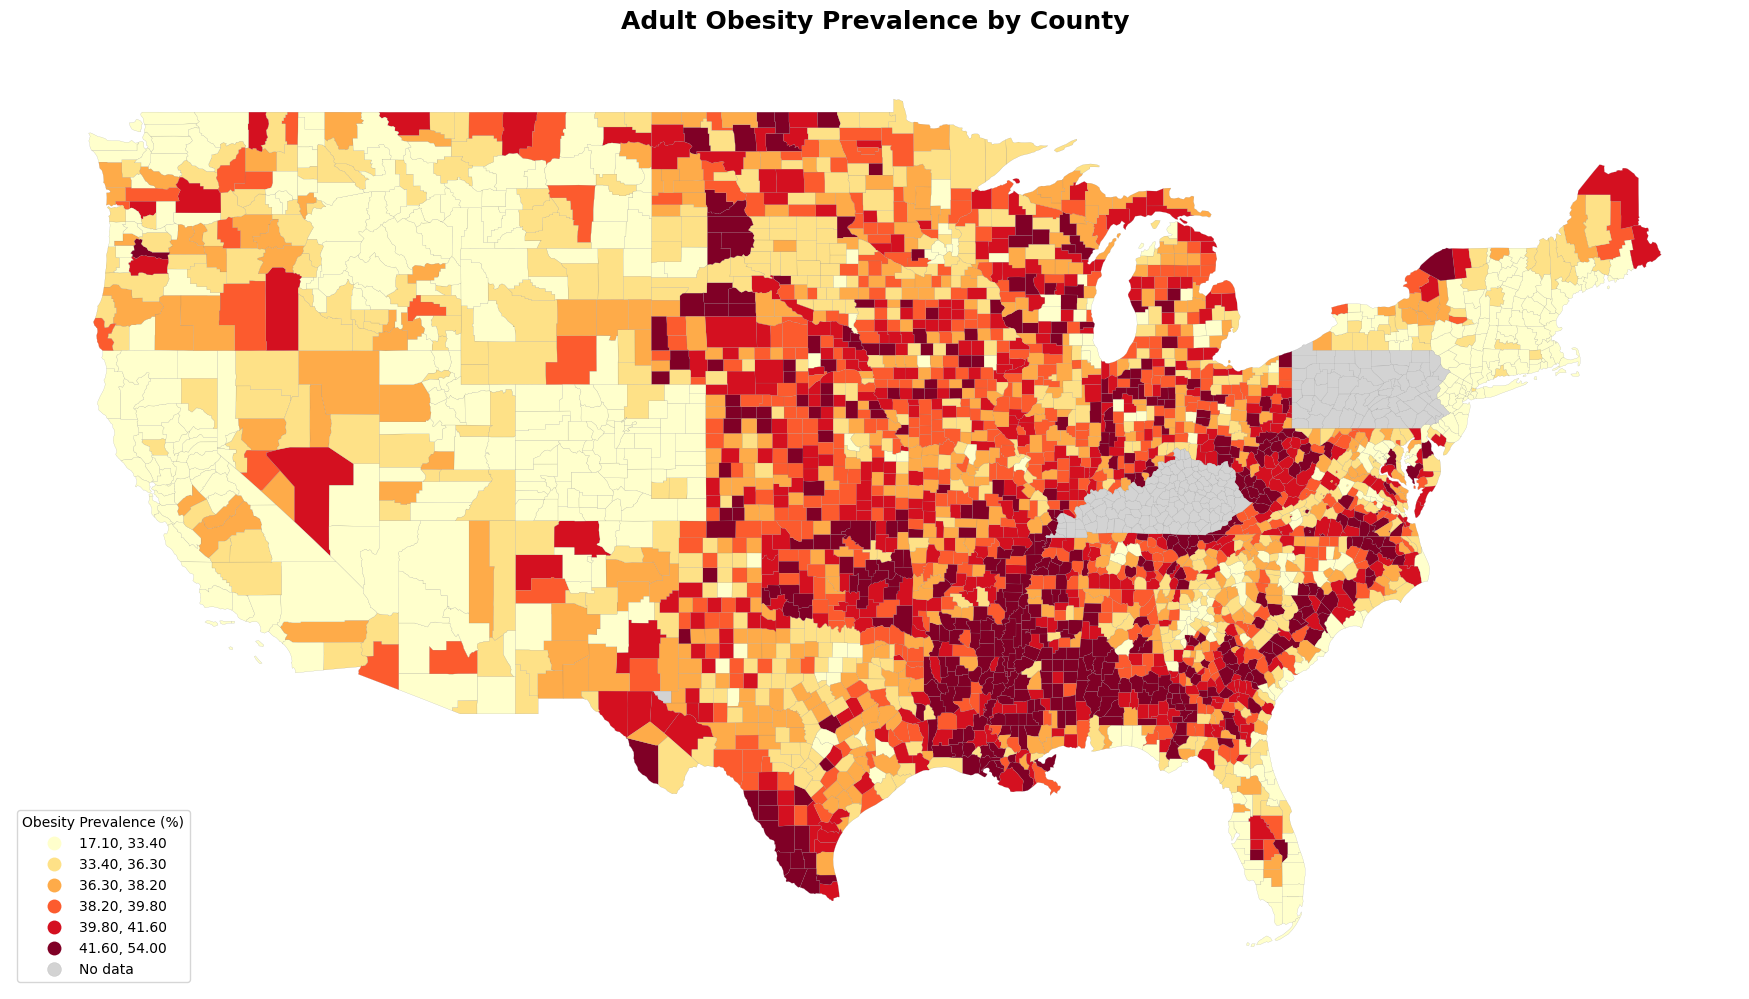

💾 Saved: map_obesity_prevalence.png


In [91]:
# --- Cell 24: Static choropleth — Obesity prevalence ---

fig, ax = plt.subplots(1, 1, figsize=(18, 10))

gdf_conus.plot(
    column='OBESITY',
    cmap='YlOrRd',
    scheme='quantiles',
    k=6,
    legend=True,
    legend_kwds={'title': 'Obesity Prevalence (%)', 'loc': 'lower left'},
    ax=ax,
    edgecolor='gray',
    linewidth=0.1,
    missing_kwds={'color': 'lightgray', 'label': 'No data'}
)

ax.set_title('Adult Obesity Prevalence by County', fontsize=18, fontweight='bold', pad=20)
ax.set_axis_off()
plt.tight_layout()
plt.savefig('map_obesity_prevalence.png', dpi=200, bbox_inches='tight')
plt.show()
print("💾 Saved: map_obesity_prevalence.png")

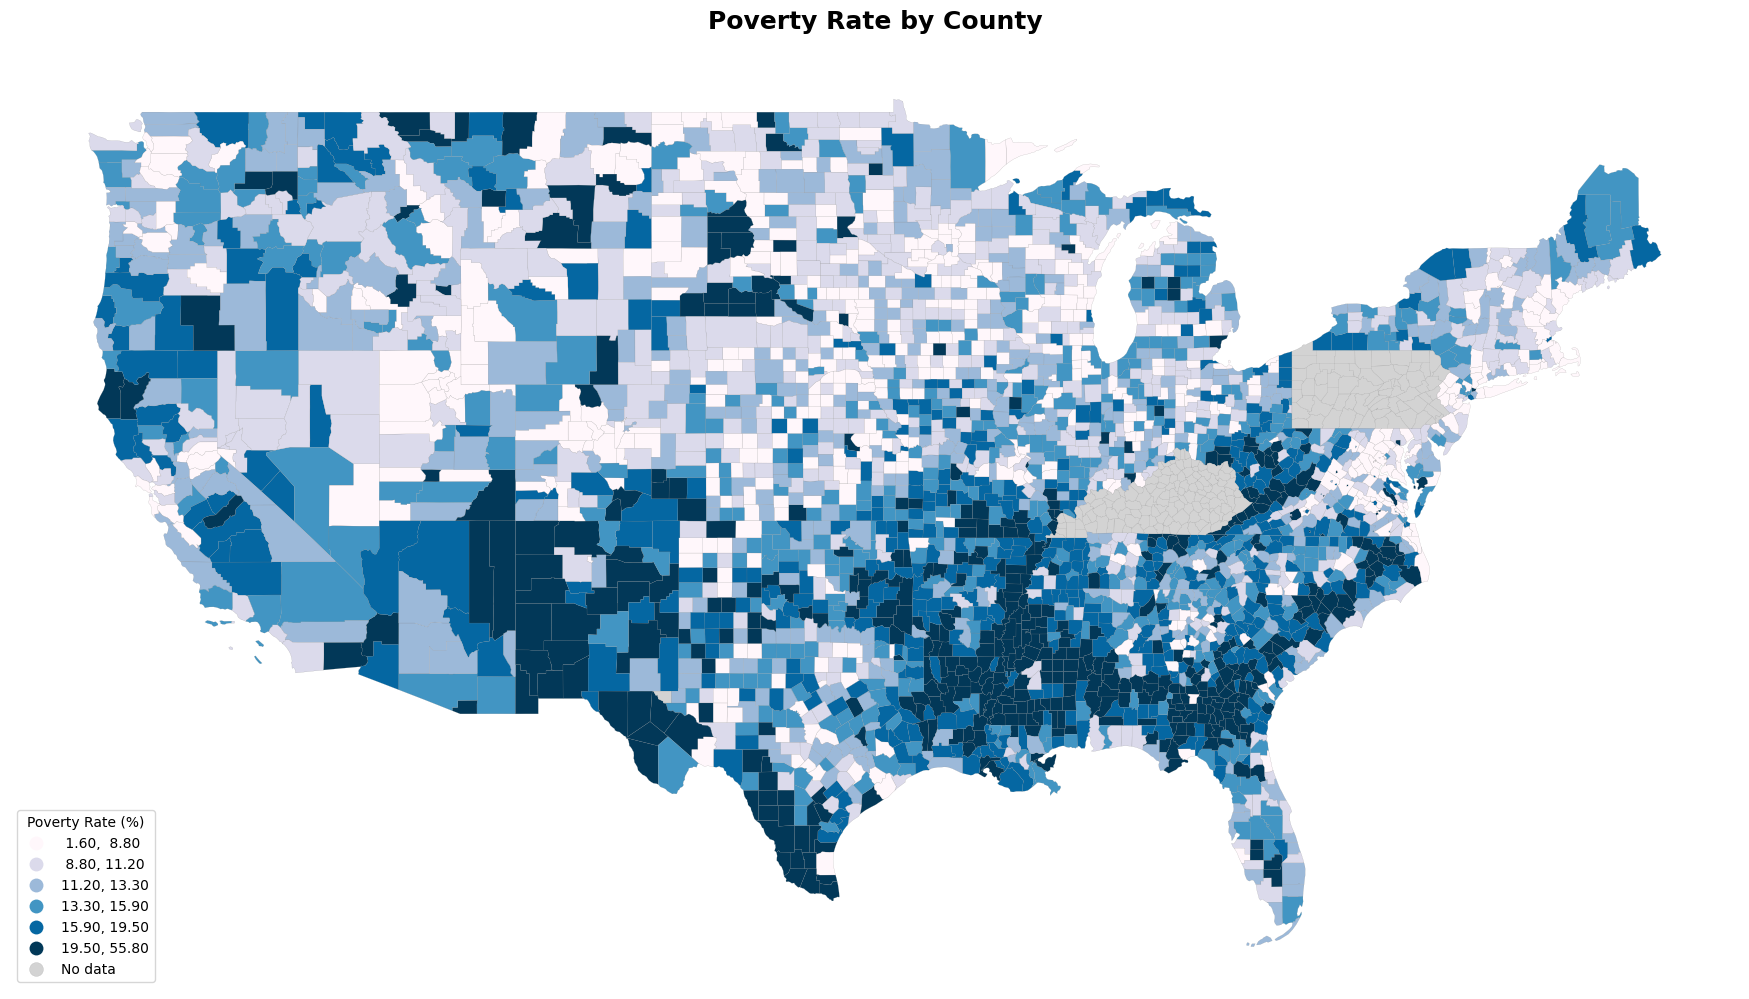

💾 Saved: map_poverty_rate.png


In [92]:
# --- Cell 25: Static choropleth — Poverty rate ---

fig, ax = plt.subplots(1, 1, figsize=(18, 10))

gdf_conus.plot(
    column='poverty_rate',
    cmap='PuBu',
    scheme='quantiles',
    k=6,
    legend=True,
    legend_kwds={'title': 'Poverty Rate (%)', 'loc': 'lower left'},
    ax=ax,
    edgecolor='gray',
    linewidth=0.1,
    missing_kwds={'color': 'lightgray', 'label': 'No data'}
)

ax.set_title('Poverty Rate by County', fontsize=18, fontweight='bold', pad=20)
ax.set_axis_off()
plt.tight_layout()
plt.savefig('map_poverty_rate.png', dpi=200, bbox_inches='tight')
plt.show()
print("💾 Saved: map_poverty_rate.png")

### Triple Burden Analysis

This is the central analytical contribution of the project. We identify counties that rank in the **top quartile (75th percentile) nationally** on three dimensions simultaneously:

1. **High diabetes prevalence** — disease burden
2. **High uninsured rate** — healthcare access barrier
3. **High poverty rate** — economic vulnerability

Counties meeting all three criteria represent places where health need is greatest and capacity to address it is most constrained. These are the communities where targeted public health investment could have the highest impact.


In [93]:

# --- Cell 26: Triple Burden Analysis ---

# Identify counties in the TOP QUARTILE on all three dimensions:
# High diabetes + High uninsured + High poverty

q75_diabetes = df_merged['DIABETES'].quantile(0.75)
q75_access = df_merged['ACCESS2'].quantile(0.75)
q75_poverty = df_merged['poverty_rate'].quantile(0.75)

print(f"Top quartile thresholds:")
print(f"  Diabetes prevalence: >= {q75_diabetes:.1f}%")
print(f"  Uninsured rate:      >= {q75_access:.1f}%")
print(f"  Poverty rate:        >= {q75_poverty:.1f}%")

gdf_conus['triple_burden'] = (
    (gdf_conus['DIABETES'] >= q75_diabetes) &
    (gdf_conus['ACCESS2'] >= q75_access) &
    (gdf_conus['poverty_rate'] >= q75_poverty)
).astype(int)

n_triple = gdf_conus['triple_burden'].sum()
pop_triple = gdf_conus.loc[gdf_conus['triple_burden'] == 1, 'population'].sum()
pop_total = gdf_conus['population'].sum()

print(f"\n🔴 TRIPLE BURDEN COUNTIES:")
print(f"   Count: {n_triple} counties ({n_triple/len(gdf_conus)*100:.1f}% of all counties)")
if pop_total > 0:
    print(f"   Population: {pop_triple:,.0f} ({pop_triple/pop_total*100:.1f}% of total)")

# Top states with most triple burden counties
triple_by_state = (
    gdf_conus[gdf_conus['triple_burden'] == 1]
    .groupby('state_abbr')
    .size()
    .sort_values(ascending=False)
    .head(10)
)
print(f"\n=== TOP STATES BY TRIPLE BURDEN COUNTY COUNT ===")
print(triple_by_state.to_string())

Top quartile thresholds:
  Diabetes prevalence: >= 12.5%
  Uninsured rate:      >= 13.4%
  Poverty rate:        >= 17.3%

🔴 TRIPLE BURDEN COUNTIES:
   Count: 326 counties (10.5% of all counties)
   Population: 14,522,104 (4.6% of total)

=== TOP STATES BY TRIPLE BURDEN COUNTY COUNT ===
state_abbr
GA    77
TX    64
MS    37
TN    20
SC    20
NC    18
FL    14
NM    13
AR    11
AL    10


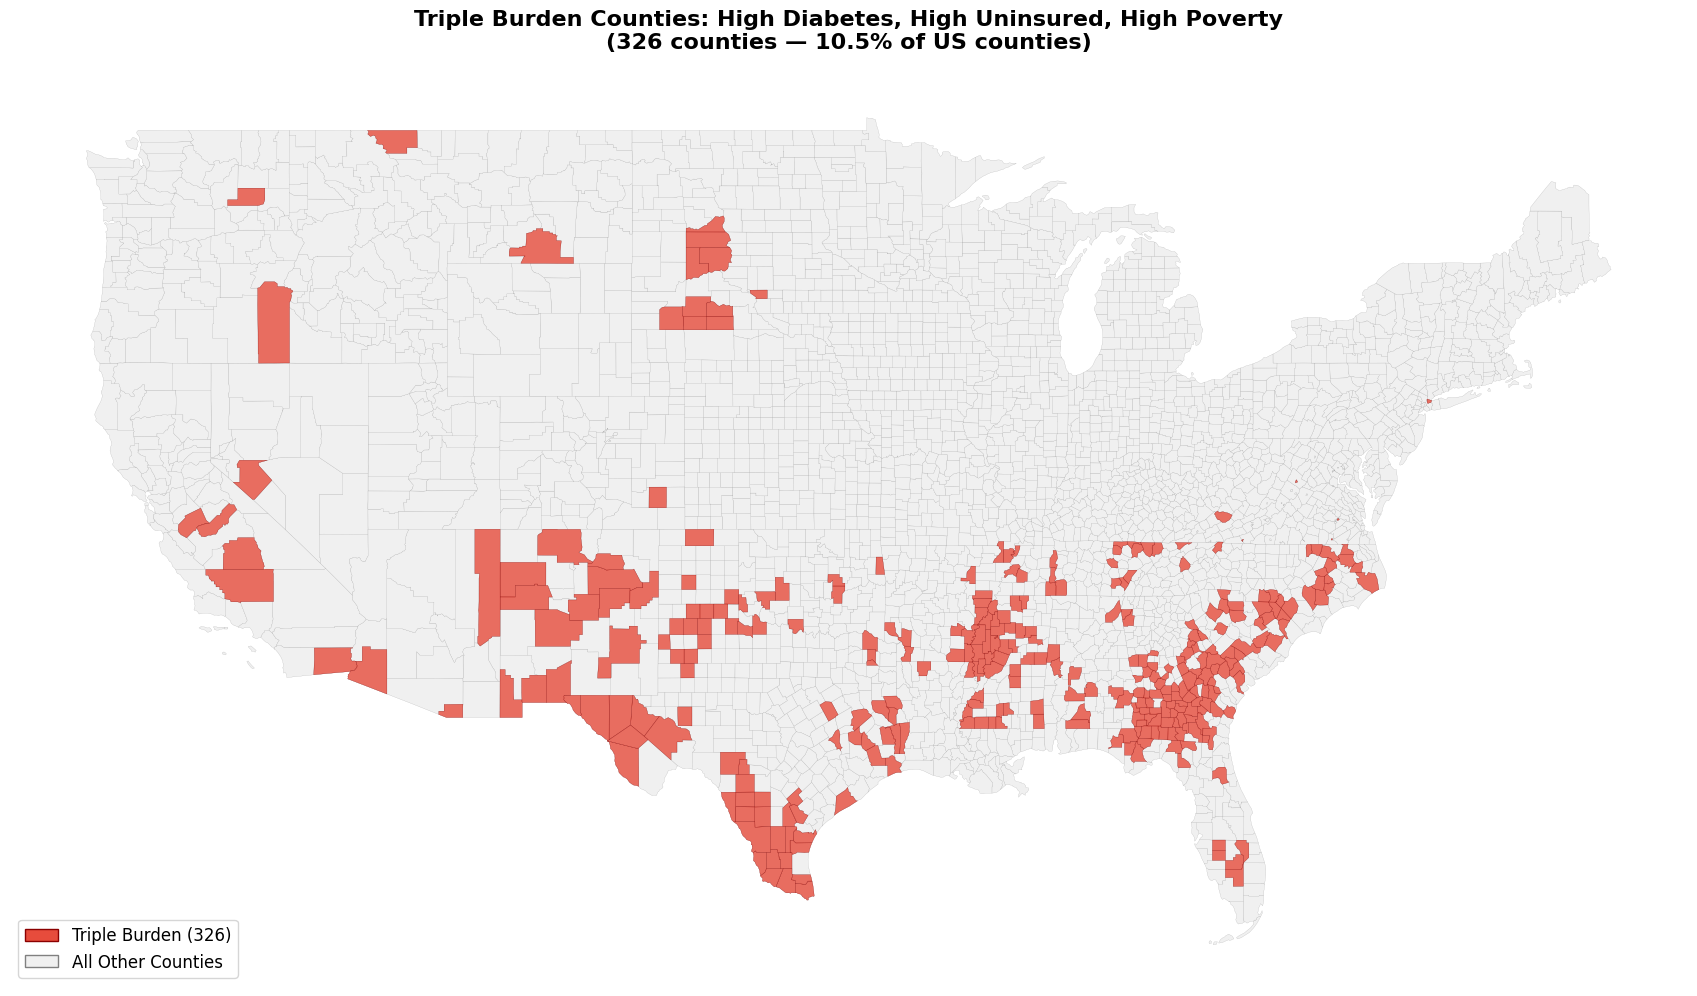

💾 Saved: map_triple_burden.png


In [94]:

# --- Cell 27: Triple Burden Map ---

fig, ax = plt.subplots(1, 1, figsize=(18, 10))

# Base layer — all counties in light gray
gdf_conus.plot(ax=ax, color='#f0f0f0', edgecolor='gray', linewidth=0.1)

# Overlay triple burden counties in red
gdf_conus[gdf_conus['triple_burden'] == 1].plot(
    ax=ax, color='#e74c3c', edgecolor='darkred', linewidth=0.2, alpha=0.8
)

ax.set_title(
    f'Triple Burden Counties: High Diabetes, High Uninsured, High Poverty\n'
    f'({n_triple} counties — {n_triple/len(gdf_conus)*100:.1f}% of US counties)',
    fontsize=16, fontweight='bold', pad=20
)
ax.set_axis_off()

# Add legend manually
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#e74c3c', edgecolor='darkred', label=f'Triple Burden ({n_triple})'),
    Patch(facecolor='#f0f0f0', edgecolor='gray', label='All Other Counties')
]
ax.legend(handles=legend_elements, loc='lower left', fontsize=12)

plt.tight_layout()
plt.savefig('map_triple_burden.png', dpi=200, bbox_inches='tight')
plt.show()
print("💾 Saved: map_triple_burden.png")

### Interactive Map

Static maps are useful for presentations and reports, but interactive maps allow stakeholders to explore the data themselves. This Folium map renders all ~3,000 counties as a choropleth with hover tooltips showing every measure for each county.

The resulting HTML file can be shared as a standalone webpage — no server required.


In [95]:


# --- Cell 28: Interactive Folium Map — Diabetes with tooltips ---

# Create a simplified GeoJSON for Folium (full detail is too heavy)
gdf_map = gdf_conus[gdf_conus['DIABETES'].notna()].copy()
gdf_map = gdf_map.to_crs(epsg=4326)  # ensure WGS84

# Simplify geometries for performance
gdf_map['geometry'] = gdf_map['geometry'].simplify(0.01, preserve_topology=True)

m = folium.Map(location=[39.8, -98.5], zoom_start=4, tiles='CartoDB positron')

# Choropleth layer
folium.Choropleth(
    geo_data=gdf_map[['fips', 'geometry']].__geo_interface__,
    data=gdf_map,
    columns=['fips', 'DIABETES'],
    key_on='feature.properties.fips',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Diabetes Prevalence (%)',
    nan_fill_color='lightgray'
).add_to(m)

# Tooltip layer
tooltip_fields = ['county_name', 'state_abbr', 'DIABETES', 'OBESITY', 'CHD',
                  'ACCESS2', 'poverty_rate']
tooltip_aliases = ['County:', 'State:', 'Diabetes %:', 'Obesity %:', 'Heart Disease %:',
                   'Uninsured %:', 'Poverty %:']

# Only include fields that exist
valid = [(f, a) for f, a in zip(tooltip_fields, tooltip_aliases) if f in gdf_map.columns]
t_fields = [v[0] for v in valid]
t_aliases = [v[1] for v in valid]

# Round numeric values for tooltip display
for col in ['DIABETES', 'OBESITY', 'CHD', 'ACCESS2', 'poverty_rate']:
    if col in gdf_map.columns:
        gdf_map[col] = gdf_map[col].round(1)

folium.GeoJson(
    gdf_map[t_fields + ['geometry']],
    style_function=lambda x: {'fillOpacity': 0, 'weight': 0},
    tooltip=GeoJsonTooltip(fields=t_fields, aliases=t_aliases, sticky=True)
).add_to(m)

m.save('map_diabetes_interactive.html')
print("💾 Saved: map_diabetes_interactive.html")
print("   Open this file in a browser to explore the interactive map!")
m


💾 Saved: map_diabetes_interactive.html
   Open this file in a browser to explore the interactive map!


In [96]:


# --- Cell 29: Save all outputs summary ---

print("=" * 60)
print("GEOSPATIAL ANALYSIS COMPLETE")
print("=" * 60)
print(f"\nDataset: {df_merged.shape[0]} counties × {df_merged.shape[1]} columns")
print(f"Data sources: CDC PLACES + Census ACS")
print(f"Triple burden counties: {n_triple}")
print(f"\n📁 FILES GENERATED:")
print(f"   📊 full_merged_dataset.csv")
print(f"   🗺️  map_diabetes_prevalence.png")
print(f"   🗺️  map_obesity_prevalence.png")
print(f"   🗺️  map_poverty_rate.png")
print(f"   🗺️  map_triple_burden.png")
print(f"   🌐 map_diabetes_interactive.html")
print(f"\n📥 Download files:")
print(f"   from google.colab import files")
print(f"   files.download('map_diabetes_interactive.html')")

GEOSPATIAL ANALYSIS COMPLETE

Dataset: 2956 counties × 14 columns
Data sources: CDC PLACES + Census ACS
Triple burden counties: 326

📁 FILES GENERATED:
   📊 full_merged_dataset.csv
   🗺️  map_diabetes_prevalence.png
   🗺️  map_obesity_prevalence.png
   🗺️  map_poverty_rate.png
   🗺️  map_triple_burden.png
   🌐 map_diabetes_interactive.html

📥 Download files:
   from google.colab import files
   files.download('map_diabetes_interactive.html')


---
## Step 4: Western North Carolina — Regional Deep Dive

National-level analysis identifies broad patterns, but public health decisions are made at the regional and local level. This section zooms into **Western North Carolina (WNC)** — 18 counties in the Appalachian mountain region — to examine how health outcomes and socioeconomic conditions vary within a single region.

WNC presents an interesting case study: it includes Asheville (Buncombe County), a mid-sized city with a health-conscious culture and relatively strong healthcare infrastructure, surrounded by rural mountain counties with very different demographic and economic profiles. This urban-rural contrast within a compact geography is exactly the kind of disparity that gets lost in state-level statistics.


In [97]:
# ============================================================
# Step 4: Western North Carolina Regional Deep Dive
# ============================================================


# --- Cell 30: Define WNC region ---

# Western North Carolina counties and their FIPS codes
# FIPS format: 37 (NC state code) + 3-digit county code
WNC_COUNTIES = {
    '37021': 'Buncombe',
    '37089': 'Henderson',
    '37115': 'Madison',
    '37087': 'Haywood',
    '37175': 'Transylvania',
    '37111': 'McDowell',
    '37199': 'Yancey',
    '37121': 'Mitchell',
    '37011': 'Avery',
    '37189': 'Watauga',
    '37099': 'Jackson',
    '37173': 'Swain',
    '37075': 'Graham',
    '37039': 'Cherokee',
    '37113': 'Macon',
    '37161': 'Rutherford',
    '37149': 'Polk',
    '37023': 'Burke'
}

# Tag counties in the merged dataset
df_merged['region'] = 'Other US'
df_merged.loc[df_merged['state_abbr'] == 'NC', 'region'] = 'North Carolina'
df_merged.loc[df_merged['fips'].isin(WNC_COUNTIES.keys()), 'region'] = 'Western NC'

print(f"Counties by region:")
print(df_merged['region'].value_counts())

Counties by region:
region
Other US          2856
North Carolina      82
Western NC          18
Name: count, dtype: int64


### Regional Comparison: WNC vs. North Carolina vs. National

We aggregate all measures to three geographic levels — WNC counties, all North Carolina counties, and all U.S. counties — to see where the region stands relative to state and national benchmarks.


In [98]:

# --- Cell 31: Build comparison table ---

COMPARE_COLS = ['DIABETES', 'OBESITY', 'CHD', 'ACCESS2', 'LPA', 'MHLTH',
                'poverty_rate', 'median_household_income']

COL_LABELS = {
    'DIABETES': 'Diabetes %',
    'OBESITY': 'Obesity %',
    'CHD': 'Heart Disease %',
    'ACCESS2': 'Uninsured %',
    'LPA': 'Physical Inactivity %',
    'MHLTH': 'Poor Mental Health %',
    'poverty_rate': 'Poverty Rate %',
    'median_household_income': 'Median Income $'
}

# Regional averages
regions = ['Western NC', 'North Carolina', 'Other US']
comparison = pd.DataFrame(index=[COL_LABELS[c] for c in COMPARE_COLS])

for region in regions:
    mask = df_merged['region'] == region
    for col in COMPARE_COLS:
        label = COL_LABELS[col]
        val = df_merged.loc[mask, col].mean()
        if col == 'median_household_income':
            comparison.loc[label, region] = f"${val:,.0f}"
        else:
            comparison.loc[label, region] = round(val, 1)

print("=== REGIONAL COMPARISON ===\n")
print(comparison.to_string())

=== REGIONAL COMPARISON ===

                      Western NC North Carolina Other US
Diabetes %                  10.0           11.5     11.2
Obesity %                   35.6           37.9     37.6
Heart Disease %              6.0            6.0      6.0
Uninsured %                 10.6           12.0     11.7
Physical Inactivity %       23.3           25.8     27.1
Poor Mental Health %        18.5           18.5     18.6
Poverty Rate %              15.0           15.7     14.2
Median Income $          $54,910        $58,997  $63,801


In [99]:

# --- Cell 32: WNC county-level detail ---

df_wnc = df_merged[df_merged['fips'].isin(WNC_COUNTIES.keys())].copy()
df_wnc['county_label'] = df_wnc['fips'].map(WNC_COUNTIES)
df_wnc = df_wnc.sort_values('DIABETES', ascending=False)

print(f"\n=== WNC COUNTY DETAIL ({len(df_wnc)} counties) ===\n")
display_cols = ['county_label', 'DIABETES', 'OBESITY', 'CHD', 'ACCESS2',
                'poverty_rate', 'median_household_income', 'population']
print(df_wnc[display_cols].to_string(index=False))

# Highlight Buncombe specifically
buncombe = df_wnc[df_wnc['county_label'] == 'Buncombe']
if len(buncombe) > 0:
    b = buncombe.iloc[0]
    print(f"\n📍 BUNCOMBE COUNTY (Asheville):")
    print(f"   Diabetes: {b['DIABETES']}%  |  Obesity: {b['OBESITY']}%  |  Heart Disease: {b['CHD']}%")
    print(f"   Uninsured: {b['ACCESS2']}%  |  Poverty: {b['poverty_rate']}%  |  Income: ${b['median_household_income']:,.0f}")



=== WNC COUNTY DETAIL (18 counties) ===

county_label  DIABETES  OBESITY  CHD  ACCESS2  poverty_rate  median_household_income  population
       Swain      12.5     40.8  6.8     11.9          19.8                    52818       13916
  Rutherford      11.1     38.0  6.5     12.0          18.4                    50512       65507
       Burke      10.9     36.7  6.4     12.4          17.0                    53732       88338
     Jackson      10.9     36.7  6.2     10.6          19.3                    51482       44574
     Watauga      10.5     37.0  6.3      9.5          24.9                    50034       54748
    McDowell      10.3     35.0  6.2     11.8          14.9                    53532       44893
       Avery      10.2     37.4  6.3     11.5          11.2                    53513       17561
    Cherokee      10.1     34.8  6.2     10.2          16.7                    49254       29959
      Yancey      10.0     35.6  6.1     11.1          15.3                    53103 

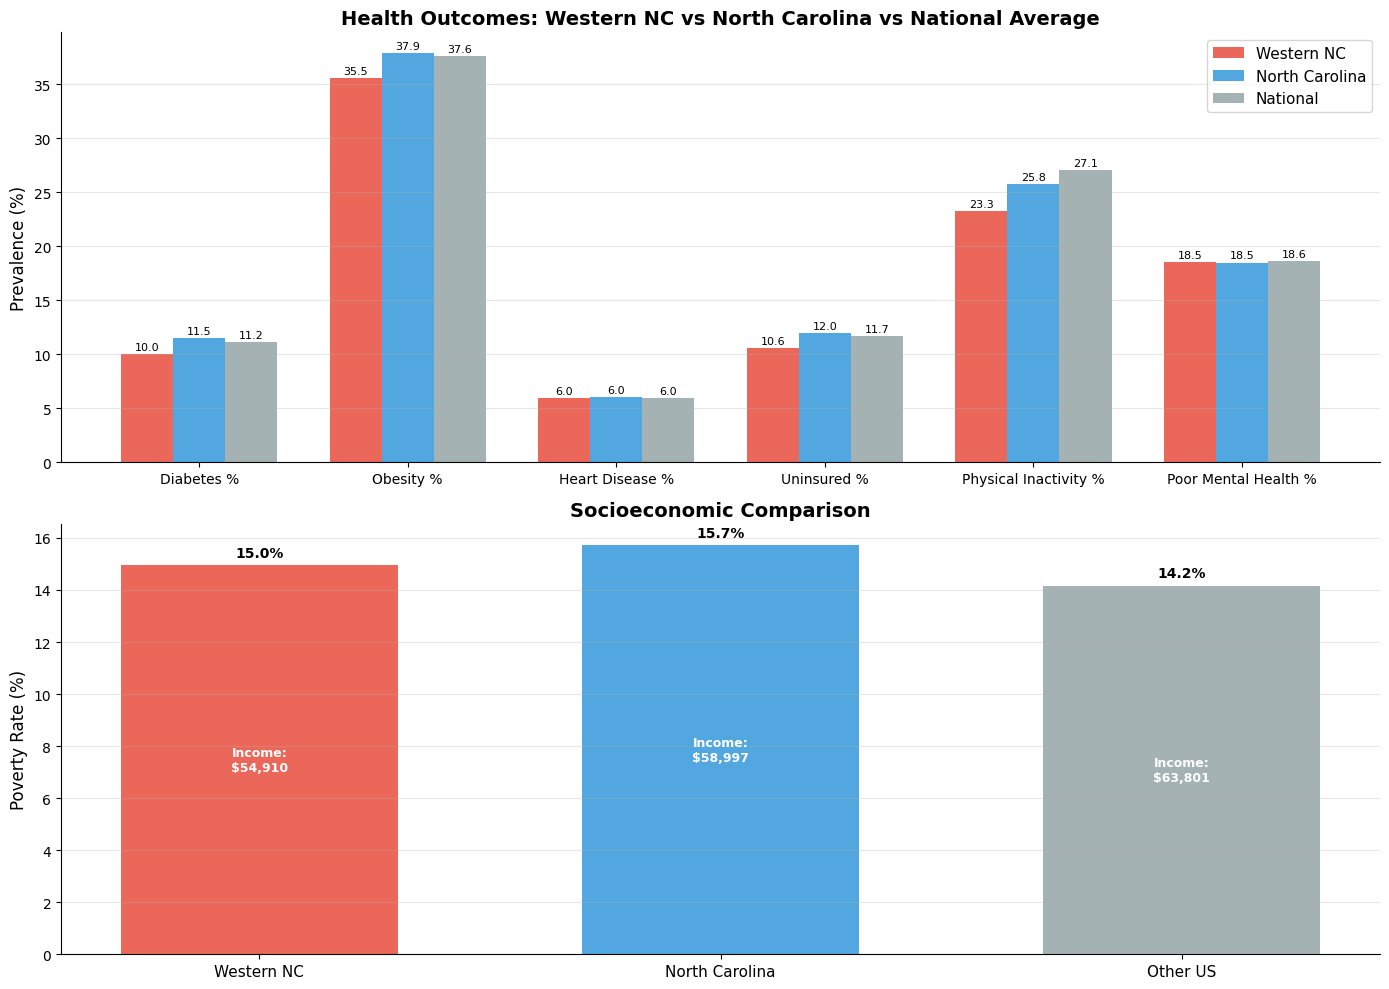

💾 Saved: wnc_comparison.png


In [100]:
# --- Cell 33: Grouped bar chart — WNC vs NC vs US ---

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Health measures
health_cols = ['DIABETES', 'OBESITY', 'CHD', 'ACCESS2', 'LPA', 'MHLTH']
health_labels = [COL_LABELS[c] for c in health_cols]

x = np.arange(len(health_cols))
width = 0.25

vals = {}
for region in regions:
    mask = df_merged['region'] == region
    vals[region] = [df_merged.loc[mask, col].mean() for col in health_cols]

ax = axes[0]
bars1 = ax.bar(x - width, vals['Western NC'], width, label='Western NC', color='#e74c3c', alpha=0.85)
bars2 = ax.bar(x, vals['North Carolina'], width, label='North Carolina', color='#3498db', alpha=0.85)
bars3 = ax.bar(x + width, vals['Other US'], width, label='National', color='#95a5a6', alpha=0.85)

ax.set_ylabel('Prevalence (%)', fontsize=12)
ax.set_title('Health Outcomes: Western NC vs North Carolina vs National Average',
             fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(health_labels, fontsize=10)
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)
ax.spines[['top', 'right']].set_visible(False)

# Add value labels on bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        h = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., h + 0.2,
                f'{h:.1f}', ha='center', va='bottom', fontsize=8)

# Socioeconomic measures
ax2 = axes[1]
econ_cols = ['poverty_rate', 'median_household_income']

# Poverty subplot
poverty_vals = [df_merged.loc[df_merged['region']==r, 'poverty_rate'].mean() for r in regions]
income_vals = [df_merged.loc[df_merged['region']==r, 'median_household_income'].mean() for r in regions]

x2 = np.arange(2)
colors = ['#e74c3c', '#3498db', '#95a5a6']

# Left: Poverty
ax2_left = ax2
bars_pov = ax2_left.bar([0, 1, 2], poverty_vals, 0.6, color=colors, alpha=0.85)
ax2_left.set_ylabel('Poverty Rate (%)', fontsize=12)
ax2_left.set_xticks([0, 1, 2])
ax2_left.set_xticklabels(regions, fontsize=11)
ax2_left.set_title('Socioeconomic Comparison', fontsize=14, fontweight='bold')
ax2_left.grid(axis='y', alpha=0.3)
ax2_left.spines[['top', 'right']].set_visible(False)

for bar, val in zip(bars_pov, poverty_vals):
    ax2_left.text(bar.get_x() + bar.get_width()/2., val + 0.2,
                  f'{val:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Add income as text annotation
for i, (region, inc) in enumerate(zip(regions, income_vals)):
    ax2_left.text(i, poverty_vals[i] / 2,
                  f'Income:\n${inc:,.0f}', ha='center', va='center',
                  fontsize=9, color='white', fontweight='bold')

plt.tight_layout()
plt.savefig('wnc_comparison.png', dpi=200, bbox_inches='tight')
plt.show()
print("💾 Saved: wnc_comparison.png")

### County-Level Heatmap

The heatmap shows every WNC county across every measure, with colors normalized to the full national range (0 = best nationally, 1 = worst nationally). This makes it easy to spot which counties face the greatest challenges and on which specific measures — the kind of actionable detail that drives resource allocation decisions.


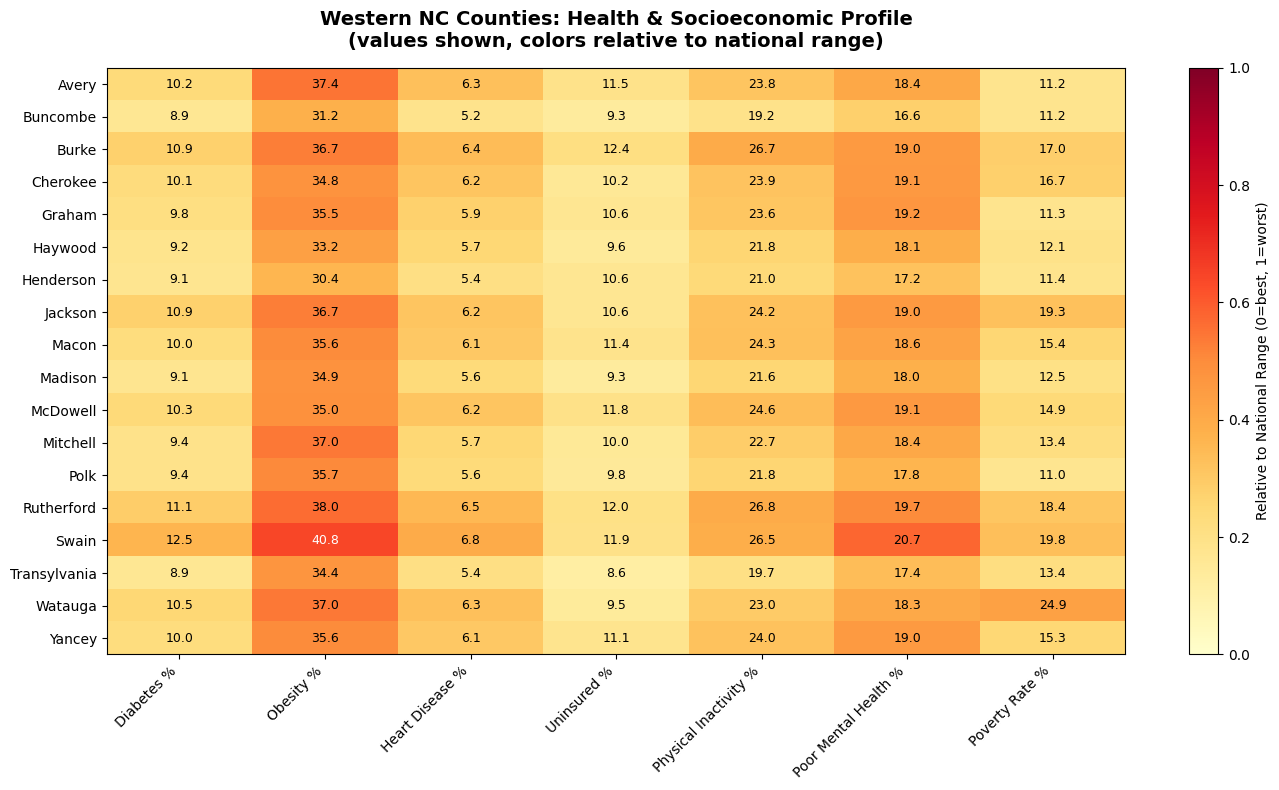

💾 Saved: wnc_county_heatmap.png


In [101]:



# --- Cell 34: WNC county-level heatmap ---

fig, ax = plt.subplots(figsize=(14, 8))

# Prepare data for heatmap
heat_cols = ['DIABETES', 'OBESITY', 'CHD', 'ACCESS2', 'LPA', 'MHLTH', 'poverty_rate']
df_heat = df_wnc.set_index('county_label')[heat_cols].copy()
df_heat.columns = [COL_LABELS.get(c, c) for c in heat_cols]
df_heat = df_heat.sort_index()

# Normalize each column to 0-1 for color mapping (relative to national range)
df_norm = df_heat.copy()
for col in df_heat.columns:
    orig_col = [k for k, v in COL_LABELS.items() if v == col][0]
    national_min = df_merged[orig_col].min()
    national_max = df_merged[orig_col].max()
    df_norm[col] = (df_heat[col] - national_min) / (national_max - national_min)

im = ax.imshow(df_norm.values, cmap='YlOrRd', aspect='auto', vmin=0, vmax=1)

ax.set_xticks(range(len(df_heat.columns)))
ax.set_yticks(range(len(df_heat.index)))
ax.set_xticklabels(df_heat.columns, rotation=45, ha='right', fontsize=10)
ax.set_yticklabels(df_heat.index, fontsize=10)

# Add actual values as text
for i in range(len(df_heat.index)):
    for j in range(len(df_heat.columns)):
        val = df_heat.iloc[i, j]
        norm_val = df_norm.iloc[i, j]
        color = 'white' if norm_val > 0.6 else 'black'
        text = f'{val:.1f}' if not pd.isna(val) else 'N/A'
        ax.text(j, i, text, ha='center', va='center', fontsize=9, color=color)

plt.colorbar(im, ax=ax, label='Relative to National Range (0=best, 1=worst)')
ax.set_title('Western NC Counties: Health & Socioeconomic Profile\n(values shown, colors relative to national range)',
             fontsize=14, fontweight='bold', pad=15)

plt.tight_layout()
plt.savefig('wnc_county_heatmap.png', dpi=200, bbox_inches='tight')
plt.show()
print("💾 Saved: wnc_county_heatmap.png")

### WNC Regional Map

A zoomed choropleth focusing specifically on WNC counties, colored by diabetes prevalence. This visualization demonstrates the ability to move between national-scale and regional-scale analysis within the same pipeline.


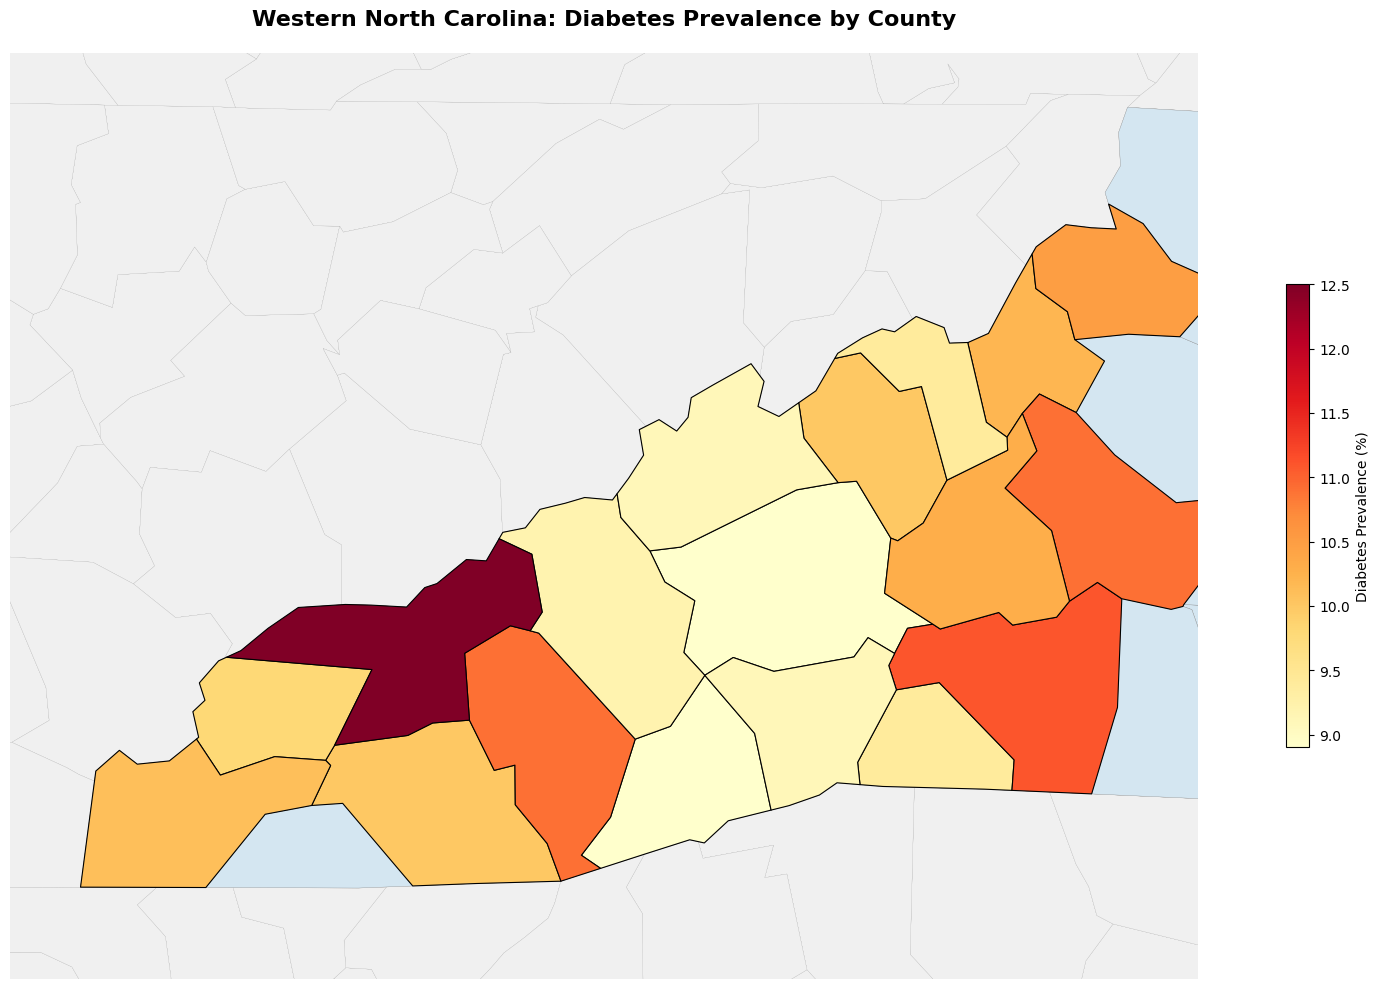

💾 Saved: wnc_regional_map.png


In [102]:
 #--- Cell 35: WNC on the map ---

# Highlight WNC counties on the national map
fig, ax = plt.subplots(1, 1, figsize=(18, 10))

# Base: all US counties light gray
gdf_conus.plot(ax=ax, color='#f0f0f0', edgecolor='gray', linewidth=0.1)

# NC counties in light blue
gdf_conus[gdf_conus['state_abbr'] == 'NC'].plot(
    ax=ax, color='#d4e6f1', edgecolor='gray', linewidth=0.2
)

# WNC counties colored by diabetes prevalence
gdf_wnc = gdf_conus[gdf_conus['fips'].isin(WNC_COUNTIES.keys())]
gdf_wnc.plot(
    column='DIABETES', cmap='YlOrRd', ax=ax,
    edgecolor='black', linewidth=0.8, legend=True,
    legend_kwds={'shrink': 0.5, 'label': 'Diabetes Prevalence (%)'}
)

ax.set_xlim(-84.5, -81.5)
ax.set_ylim(34.8, 36.7)
ax.set_title('Western North Carolina: Diabetes Prevalence by County',
             fontsize=16, fontweight='bold', pad=20)
ax.set_axis_off()

plt.tight_layout()
plt.savefig('wnc_regional_map.png', dpi=200, bbox_inches='tight')
plt.show()
print("💾 Saved: wnc_regional_map.png")

### Key Findings Summary

A structured comparison of WNC against state and national benchmarks, with directional indicators (▲/▼) showing where the region performs above or below the national average. We also identify the highest-need counties within WNC — those exceeding state averages on both diabetes and poverty.


In [103]:


# --- Cell 36: Key findings summary ---

print("=" * 60)
print("📍 WESTERN NC DEEP DIVE — KEY FINDINGS")
print("=" * 60)

wnc_avg = df_merged[df_merged['region'] == 'Western NC']
nc_avg = df_merged[df_merged['region'] == 'North Carolina']
us_avg = df_merged[df_merged['region'] == 'Other US']

print(f"\n{'Measure':<25} {'WNC':>8} {'NC':>8} {'US':>8} {'WNC vs US':>10}")
print("-" * 62)
for col in health_cols:
    w = wnc_avg[col].mean()
    n = nc_avg[col].mean()
    u = us_avg[col].mean()
    diff = w - u
    arrow = "▲" if diff > 0 else "▼"
    print(f"{COL_LABELS[col]:<25} {w:>7.1f}% {n:>7.1f}% {u:>7.1f}% {arrow}{abs(diff):>+7.1f}%")

print(f"\n{'Poverty Rate':<25} {wnc_avg['poverty_rate'].mean():>7.1f}% {nc_avg['poverty_rate'].mean():>7.1f}% {us_avg['poverty_rate'].mean():>7.1f}%")
print(f"{'Median Income':<25} ${wnc_avg['median_household_income'].mean():>7,.0f} ${nc_avg['median_household_income'].mean():>7,.0f} ${us_avg['median_household_income'].mean():>7,.0f}")

# Identify highest-need WNC counties
print(f"\n=== HIGHEST-NEED WNC COUNTIES ===")
print("(Above NC average on diabetes AND poverty)")
high_need = df_wnc[
    (df_wnc['DIABETES'] > nc_avg['DIABETES'].mean()) &
    (df_wnc['poverty_rate'] > nc_avg['poverty_rate'].mean())
]
if len(high_need) > 0:
    for _, row in high_need.sort_values('DIABETES', ascending=False).iterrows():
        print(f"  🔴 {row['county_label']}: Diabetes {row['DIABETES']}%, Poverty {row['poverty_rate']}%")
else:
    print("  None found — WNC may perform better than state average")

📍 WESTERN NC DEEP DIVE — KEY FINDINGS

Measure                        WNC       NC       US  WNC vs US
--------------------------------------------------------------
Diabetes %                   10.0%    11.5%    11.2% ▼   +1.1%
Obesity %                    35.5%    37.9%    37.6% ▼   +2.1%
Heart Disease %               6.0%     6.0%     6.0% ▲   +0.0%
Uninsured %                  10.6%    12.0%    11.7% ▼   +1.1%
Physical Inactivity %        23.3%    25.8%    27.1% ▼   +3.8%
Poor Mental Health %         18.5%    18.5%    18.6% ▼   +0.1%

Poverty Rate                 15.0%    15.7%    14.2%
Median Income             $ 54,910 $ 58,997 $ 63,801

=== HIGHEST-NEED WNC COUNTIES ===
(Above NC average on diabetes AND poverty)
  🔴 Swain: Diabetes 12.5%, Poverty 19.8%
